# GNNs

## mass into account

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GeneralConv
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from datagen import generate_dataset, generate_dataset_nbodies
from tqdm import tqdm



def fully_connected(input_dim, hidden_dim, output_dim, num_layers):
    layers = []
    # Add hidden layers
    for _ in range(num_layers):
        layers.append(torch.nn.Linear(input_dim, hidden_dim))
        layers.append(torch.nn.ReLU())
        input_dim = hidden_dim
    # Add output layer
    layers.append(torch.nn.Linear(hidden_dim, output_dim))
    return torch.nn.Sequential(*layers)

# Function to create edge weights based on mass difference
def create_edge_attributes_based_on_mass_and_dist(data):
    row, col = data.edge_index  # Get indices of connected nodes
    # Get masses for each node in the connection
    pos_row = data.x[row][:, :3]
    pos_col = data.x[col][:, :3]
    distance = torch.norm(pos_row - pos_col, dim=1)  # Calculate distance between nodes
    mass_row = data.x[row][:, -1]
    mass_col = data.x[col][:, -1]
    mass_prod = mass_row * mass_col  # Multiply masses
    data.edge_attr = torch.stack([mass_prod, distance], dim=1)  # Concatenate edge attributes
    
    return data

class ParticleGNN(torch.nn.Module):
    def __init__(self, input_dim, fc_dim, fc_layers, gnn_dim, message_passing_steps, output_dim):
        super(ParticleGNN, self).__init__()
        # Encoder for initial node features
        self.encoder = fully_connected(input_dim, fc_dim, gnn_dim, fc_layers)
        
        # GeneralConv layers for message passing
        self.gnns = []
        for i in range(message_passing_steps):
            gnn = GeneralConv(in_channels=gnn_dim, out_channels=gnn_dim, aggr='add', directed_msg=False, in_edge_channels=2)
            setattr(self, f'gnn_{i}', gnn)
            self.gnns.append(gnn)
        
        # Decoder to transform final node features to output
        self.decoder = fully_connected(gnn_dim, fc_dim, output_dim, fc_layers)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr  # Use edge_attr instead of edge_weight
        x = self.encoder(x)
        
        for gnn in self.gnns:
            x = F.relu(gnn(x, edge_index, edge_attr=edge_attr))  # Pass edge_attr to GeneralConv
        
        x = self.decoder(x)
        return x



# Function to convert particles to a torch_geometric Data object
def transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, radius):
    # Extract features for each particle: [x, y, z, vx, vy, vz, mass]

    
    # Create edges based on radius
    edge_index = radius_graph(positions, r=radius)
    # for every node, connect it to top 2 biggest nodes

    biggest_nodes_index = torch.argsort(features[:, -1], descending=True)[:2]
    for i in range(features.shape[0]):
        if i not in biggest_nodes_index:
            edge_index = torch.cat((edge_index, torch.tensor([[i, biggest_nodes_index[0]], [i, biggest_nodes_index[1]]], dtype=torch.long)), 1)
            edge_index = torch.cat((edge_index, torch.tensor([[biggest_nodes_index[0], i], [biggest_nodes_index[1], i]], dtype=torch.long)), 1)



    
    # Create data object
    graph_data = Data(x=features, edge_index=edge_index)
    
    # Add edge weights based on mass
    graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
    return graph_data



  


In [2]:
def euclidean_distance(a, b):
    return torch.sqrt(torch.sum((a - b)**2, dim=-1) + 1e-12)
def mean_distance(a, b):
    return torch.mean(euclidean_distance(a, b))

In [ ]:
import torch
def generate_graph_dataset(data, radius):
    graphs = []
    for i in tqdm(range(len(data))):
        masses = torch.tensor(data[i]['masses']).unsqueeze(-1)
        positions = torch.tensor(data[i]['pos'])
        velocities = torch.tensor(data[i]['vel'])
        Gs = torch.ones_like(masses) 
        softening = torch.ones_like(masses) * 0.1
        features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
        graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, radius)
        graph_data.y = torch.tensor(data[i]['acc'])
        graphs.append(graph_data)
    return graphs

In [9]:
# Initialize model and optimizer
model = ParticleGNN(input_dim=9, fc_dim=128, fc_layers=1, gnn_dim=128, message_passing_steps=5, output_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [10]:

ROUNDS = 50
EPOCHS = 4
SCENES = 25
WINDOW_SIZE = 0
N_BODIES = 3
BATCH_SIZE = 32
RADIUS = 2.0


# Training loop
model.train()
for r in range(ROUNDS):
    print(f'--- Round {r} ---')
    data = generate_dataset_nbodies(n_scenes=SCENES, n_bodies=N_BODIES)
    print('Converting to graphs...')
    graphs = generate_graph_dataset(data, RADIUS)
    dataloader = DataLoader(graphs, batch_size=BATCH_SIZE)
    print('Training...')
    for epoch in range(EPOCHS):
        epoch_losses = []
        print(f'Epoch {epoch+1}')
        for data in tqdm(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = mean_distance(out, data.y)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        print(f'Epoch {epoch+1}, Loss: {torch.tensor(epoch_losses).mean()}')
    del data, graphs, dataloader
    torch.cuda.empty_cache()
    torch.save(model.state_dict(), f'./models/particle_gnn_{r}.pth')
    







--- Round 0 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.76it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 120.49it/s]


Epoch 1, Loss: 1.601000189781189
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 119.85it/s]


Epoch 2, Loss: 1.2435005903244019
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 121.83it/s]


Epoch 3, Loss: 1.1206097602844238
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 122.29it/s]


Epoch 4, Loss: 1.0359660387039185
--- Round 1 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 18.11it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 126.58it/s]


Epoch 1, Loss: 1.51865553855896
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 126.58it/s]


Epoch 2, Loss: 1.2688871622085571
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 124.62it/s]


Epoch 3, Loss: 1.1191394329071045
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 114.42it/s]


Epoch 4, Loss: 1.025037407875061
--- Round 2 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 19.20it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 123.88it/s]


Epoch 1, Loss: 0.9993913769721985
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 126.84it/s]


Epoch 2, Loss: 0.8235064744949341
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 124.80it/s]


Epoch 3, Loss: 0.7493658661842346
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 122.52it/s]


Epoch 4, Loss: 0.6935611963272095
--- Round 3 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.36it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 124.04it/s]


Epoch 1, Loss: 1.2892258167266846
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 125.15it/s]


Epoch 2, Loss: 1.047183871269226
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 124.33it/s]


Epoch 3, Loss: 0.9071728587150574
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 122.61it/s]


Epoch 4, Loss: 0.834402322769165
--- Round 4 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 17.65it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 123.39it/s]


Epoch 1, Loss: 0.923324465751648
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 118.66it/s]


Epoch 2, Loss: 0.7516908645629883
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 122.36it/s]


Epoch 3, Loss: 0.6887844800949097
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 121.68it/s]


Epoch 4, Loss: 0.6340028047561646
--- Round 5 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 18.75it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 120.40it/s]


Epoch 1, Loss: 0.8264866471290588
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 123.48it/s]


Epoch 2, Loss: 0.6669699549674988
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 122.62it/s]


Epoch 3, Loss: 0.6070145964622498
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 116.20it/s]


Epoch 4, Loss: 0.5805982351303101
--- Round 6 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.34it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 117.56it/s]


Epoch 1, Loss: 0.8545188903808594
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 123.58it/s]


Epoch 2, Loss: 0.6949681639671326
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 124.34it/s]


Epoch 3, Loss: 0.6348690986633301
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 121.24it/s]


Epoch 4, Loss: 0.5906832814216614
--- Round 7 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.17it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 119.97it/s]


Epoch 1, Loss: 0.7186489105224609
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 121.80it/s]


Epoch 2, Loss: 0.5859317779541016
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 123.81it/s]


Epoch 3, Loss: 0.5461816191673279
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 125.26it/s]


Epoch 4, Loss: 0.5194573998451233
--- Round 8 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.93it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 121.49it/s]


Epoch 1, Loss: 0.8519816994667053
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 122.14it/s]


Epoch 2, Loss: 0.6828638315200806
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 113.07it/s]


Epoch 3, Loss: 0.6114434599876404
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 116.52it/s]


Epoch 4, Loss: 0.5853233337402344
--- Round 9 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 17.57it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:07<00:00, 110.46it/s]


Epoch 1, Loss: 0.7169442176818848
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 122.84it/s]


Epoch 2, Loss: 0.5871886610984802
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 118.04it/s]


Epoch 3, Loss: 0.5373439788818359
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 115.79it/s]


Epoch 4, Loss: 0.5017410516738892
--- Round 10 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.58it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:07<00:00, 108.38it/s]


Epoch 1, Loss: 0.9438878297805786
Epoch 2


100%|██████████| 782/782 [00:07<00:00, 110.92it/s]


Epoch 2, Loss: 0.7336626648902893
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 118.76it/s]


Epoch 3, Loss: 0.6746201515197754
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 121.66it/s]


Epoch 4, Loss: 0.6226614713668823
--- Round 11 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 18.03it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 120.91it/s]


Epoch 1, Loss: 0.5938881635665894
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 119.65it/s]


Epoch 2, Loss: 0.484305739402771
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 120.68it/s]


Epoch 3, Loss: 0.45273876190185547
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 120.20it/s]


Epoch 4, Loss: 0.43259677290916443
--- Round 12 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.33it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 121.67it/s]


Epoch 1, Loss: 1.0011053085327148
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 120.97it/s]


Epoch 2, Loss: 0.7922633290290833
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 125.76it/s]


Epoch 3, Loss: 0.7161239981651306
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 124.09it/s]


Epoch 4, Loss: 0.6624357104301453
--- Round 13 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 17.08it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 122.03it/s]


Epoch 1, Loss: 0.6310988068580627
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 121.57it/s]


Epoch 2, Loss: 0.5007518529891968
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 122.50it/s]


Epoch 3, Loss: 0.4828520119190216
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 120.08it/s]


Epoch 4, Loss: 0.45608314871788025
--- Round 14 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 18.10it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 119.68it/s]


Epoch 1, Loss: 0.629962682723999
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 123.86it/s]


Epoch 2, Loss: 0.5323147773742676
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 123.68it/s]


Epoch 3, Loss: 0.48444828391075134
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 127.68it/s]


Epoch 4, Loss: 0.4459909498691559
--- Round 15 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.81it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 118.53it/s]


Epoch 1, Loss: 0.893062949180603
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 122.17it/s]


Epoch 2, Loss: 0.7082168459892273
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 123.48it/s]


Epoch 3, Loss: 0.6557693481445312
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 124.01it/s]


Epoch 4, Loss: 0.6172547340393066
--- Round 16 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.65it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 121.98it/s]


Epoch 1, Loss: 0.6826555728912354
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 116.60it/s]


Epoch 2, Loss: 0.5743580460548401
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 121.61it/s]


Epoch 3, Loss: 0.5194579362869263
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 123.72it/s]


Epoch 4, Loss: 0.4974571168422699
--- Round 17 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 15.93it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 127.86it/s]


Epoch 1, Loss: 0.6437211036682129
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 128.00it/s]


Epoch 2, Loss: 0.5325864553451538
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 120.31it/s]


Epoch 3, Loss: 0.5011105537414551
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 113.99it/s]


Epoch 4, Loss: 0.47626978158950806
--- Round 18 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 17.58it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 124.04it/s]


Epoch 1, Loss: 0.5089637041091919
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 125.93it/s]


Epoch 2, Loss: 0.42742007970809937
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 127.90it/s]


Epoch 3, Loss: 0.40778934955596924
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 122.22it/s]


Epoch 4, Loss: 0.37917739152908325
--- Round 19 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 17.79it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 121.63it/s]


Epoch 1, Loss: 0.6990303993225098
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 124.43it/s]


Epoch 2, Loss: 0.576141893863678
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 127.03it/s]


Epoch 3, Loss: 0.5277606248855591
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 126.79it/s]


Epoch 4, Loss: 0.4925040602684021
--- Round 20 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.28it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 120.86it/s]


Epoch 1, Loss: 0.5975911021232605
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 128.31it/s]


Epoch 2, Loss: 0.4913124740123749
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 127.85it/s]


Epoch 3, Loss: 0.4642370939254761
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 124.01it/s]


Epoch 4, Loss: 0.4284530580043793
--- Round 21 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 17.58it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 119.05it/s]


Epoch 1, Loss: 0.783991277217865
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 122.99it/s]


Epoch 2, Loss: 0.6277896761894226
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 123.57it/s]


Epoch 3, Loss: 0.5691292881965637
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 123.45it/s]


Epoch 4, Loss: 0.530998706817627
--- Round 22 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.25it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 121.45it/s]


Epoch 1, Loss: 0.7191434502601624
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 120.55it/s]


Epoch 2, Loss: 0.5793481469154358
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 124.07it/s]


Epoch 3, Loss: 0.5441406965255737
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 124.66it/s]


Epoch 4, Loss: 0.5103910565376282
--- Round 23 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 17.30it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 118.34it/s]


Epoch 1, Loss: 0.7619256377220154
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 117.61it/s]


Epoch 2, Loss: 0.6459529995918274
Epoch 3


100%|██████████| 782/782 [00:07<00:00, 107.21it/s]


Epoch 3, Loss: 0.588662326335907
Epoch 4


100%|██████████| 782/782 [00:07<00:00, 109.38it/s]


Epoch 4, Loss: 0.5534806847572327
--- Round 24 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 17.11it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 113.84it/s]


Epoch 1, Loss: 0.5073274374008179
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 122.14it/s]


Epoch 2, Loss: 0.4211951494216919
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 117.17it/s]


Epoch 3, Loss: 0.39164215326309204
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 116.34it/s]


Epoch 4, Loss: 0.3805789351463318
--- Round 25 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.04it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 122.33it/s]


Epoch 1, Loss: 0.5472368001937866
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 127.03it/s]


Epoch 2, Loss: 0.4576341211795807
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 123.85it/s]


Epoch 3, Loss: 0.42462462186813354
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 119.45it/s]


Epoch 4, Loss: 0.39642179012298584
--- Round 26 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 15.71it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 113.05it/s]


Epoch 1, Loss: 0.4560638964176178
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 125.90it/s]


Epoch 2, Loss: 0.3803548514842987
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 125.73it/s]


Epoch 3, Loss: 0.34416666626930237
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 123.35it/s]


Epoch 4, Loss: 0.33298540115356445
--- Round 27 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 14.61it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 117.45it/s]


Epoch 1, Loss: 0.84485924243927
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 124.05it/s]


Epoch 2, Loss: 0.6697590351104736
Epoch 3


100%|██████████| 782/782 [00:07<00:00, 110.49it/s]


Epoch 3, Loss: 0.5862378478050232
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 114.54it/s]


Epoch 4, Loss: 0.5503864884376526
--- Round 28 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 15.32it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 115.32it/s]


Epoch 1, Loss: 0.47189924120903015
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 115.40it/s]


Epoch 2, Loss: 0.39020320773124695
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 122.72it/s]


Epoch 3, Loss: 0.3579566776752472
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 126.92it/s]


Epoch 4, Loss: 0.3501124083995819
--- Round 29 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.57it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 118.79it/s]


Epoch 1, Loss: 1.0074766874313354
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 118.93it/s]


Epoch 2, Loss: 0.7908948659896851
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 117.87it/s]


Epoch 3, Loss: 0.709883451461792
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 114.28it/s]


Epoch 4, Loss: 0.6706000566482544
--- Round 30 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 15.07it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 118.69it/s]


Epoch 1, Loss: 0.4836204946041107
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 121.80it/s]


Epoch 2, Loss: 0.3964836597442627
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 125.84it/s]


Epoch 3, Loss: 0.37184879183769226
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 122.13it/s]


Epoch 4, Loss: 0.363804429769516
--- Round 31 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 14.37it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 120.13it/s]


Epoch 1, Loss: 1.0014368295669556
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 121.69it/s]


Epoch 2, Loss: 0.7636338472366333
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 123.65it/s]


Epoch 3, Loss: 0.6906532049179077
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 125.07it/s]


Epoch 4, Loss: 0.648645281791687
--- Round 32 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 13.93it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:07<00:00, 110.58it/s]


Epoch 1, Loss: 0.5665220022201538
Epoch 2


100%|██████████| 782/782 [00:07<00:00, 111.00it/s]


Epoch 2, Loss: 0.4501204192638397
Epoch 3


100%|██████████| 782/782 [00:07<00:00, 104.20it/s]


Epoch 3, Loss: 0.42198675870895386
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 124.04it/s]


Epoch 4, Loss: 0.4078086316585541
--- Round 33 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.06it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 126.32it/s]


Epoch 1, Loss: 0.54994136095047
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 116.82it/s]


Epoch 2, Loss: 0.45248425006866455
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 120.28it/s]


Epoch 3, Loss: 0.42775607109069824
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 123.71it/s]


Epoch 4, Loss: 0.40378275513648987
--- Round 34 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.10it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 122.65it/s]


Epoch 1, Loss: 0.5554981827735901
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 125.65it/s]


Epoch 2, Loss: 0.46599632501602173
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 124.59it/s]


Epoch 3, Loss: 0.42382434010505676
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 121.37it/s]


Epoch 4, Loss: 0.39754530787467957
--- Round 35 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 15.44it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 116.79it/s]


Epoch 1, Loss: 0.5996742844581604
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 120.91it/s]


Epoch 2, Loss: 0.4982384145259857
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 125.13it/s]


Epoch 3, Loss: 0.45461204648017883
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 127.58it/s]


Epoch 4, Loss: 0.4357842206954956
--- Round 36 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.36it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 119.78it/s]


Epoch 1, Loss: 0.5578382611274719
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 122.86it/s]


Epoch 2, Loss: 0.47089216113090515
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 123.21it/s]


Epoch 3, Loss: 0.4388676583766937
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 120.66it/s]


Epoch 4, Loss: 0.42345601320266724
--- Round 37 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.18it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:07<00:00, 109.00it/s]


Epoch 1, Loss: 0.504571259021759
Epoch 2


100%|██████████| 782/782 [00:07<00:00, 110.74it/s]


Epoch 2, Loss: 0.4235630929470062
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 111.87it/s]


Epoch 3, Loss: 0.39322665333747864
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 122.14it/s]


Epoch 4, Loss: 0.3782123327255249
--- Round 38 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 15.10it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 119.54it/s]


Epoch 1, Loss: 0.48421382904052734
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 120.18it/s]


Epoch 2, Loss: 0.4073675870895386
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 121.06it/s]


Epoch 3, Loss: 0.37987321615219116
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 122.83it/s]


Epoch 4, Loss: 0.3660229444503784
--- Round 39 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.11it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 119.51it/s]


Epoch 1, Loss: 0.7317681908607483
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 120.31it/s]


Epoch 2, Loss: 0.5817463397979736
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 125.22it/s]


Epoch 3, Loss: 0.5181228518486023
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 123.73it/s]


Epoch 4, Loss: 0.4998812973499298
--- Round 40 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 15.00it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 116.63it/s]


Epoch 1, Loss: 0.5258328914642334
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 120.23it/s]


Epoch 2, Loss: 0.44670093059539795
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 121.24it/s]


Epoch 3, Loss: 0.4186459183692932
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 124.32it/s]


Epoch 4, Loss: 0.39240363240242004
--- Round 41 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 15.27it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 124.31it/s]


Epoch 1, Loss: 0.4471104145050049
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 123.72it/s]


Epoch 2, Loss: 0.36777517199516296
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 116.51it/s]


Epoch 3, Loss: 0.3412441313266754
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 118.06it/s]


Epoch 4, Loss: 0.3316332697868347
--- Round 42 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 15.83it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 128.19it/s]


Epoch 1, Loss: 0.7492526173591614
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 126.15it/s]


Epoch 2, Loss: 0.6113442182540894
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 122.60it/s]


Epoch 3, Loss: 0.5596563220024109
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 124.28it/s]


Epoch 4, Loss: 0.5306024551391602
--- Round 43 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 15.43it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 127.25it/s]


Epoch 1, Loss: 0.525377094745636
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 125.88it/s]


Epoch 2, Loss: 0.44445231556892395
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 123.44it/s]


Epoch 3, Loss: 0.41534584760665894
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 124.04it/s]


Epoch 4, Loss: 0.39440199732780457
--- Round 44 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 16.56it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 119.98it/s]


Epoch 1, Loss: 0.5952173471450806
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 122.06it/s]


Epoch 2, Loss: 0.5067040920257568
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 125.63it/s]


Epoch 3, Loss: 0.47103166580200195
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 127.64it/s]


Epoch 4, Loss: 0.43871739506721497
--- Round 45 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 15.45it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 125.19it/s]


Epoch 1, Loss: 0.5789700746536255
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 125.86it/s]


Epoch 2, Loss: 0.4734635651111603
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 125.59it/s]


Epoch 3, Loss: 0.44219911098480225
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 120.35it/s]


Epoch 4, Loss: 0.41280215978622437
--- Round 46 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 15.91it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 120.75it/s]


Epoch 1, Loss: 0.5043348670005798
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 125.33it/s]


Epoch 2, Loss: 0.4211871922016144
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 124.20it/s]


Epoch 3, Loss: 0.3905905485153198
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 124.05it/s]


Epoch 4, Loss: 0.3742125928401947
--- Round 47 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 17.80it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 114.91it/s]


Epoch 1, Loss: 0.4161761403083801
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 122.30it/s]


Epoch 2, Loss: 0.3433525264263153
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 126.87it/s]


Epoch 3, Loss: 0.324640691280365
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 122.36it/s]


Epoch 4, Loss: 0.31850287318229675
--- Round 48 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 15.92it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 121.16it/s]


Epoch 1, Loss: 0.5504928231239319
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 119.32it/s]


Epoch 2, Loss: 0.4554358720779419
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 121.72it/s]


Epoch 3, Loss: 0.4296117424964905
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 124.60it/s]


Epoch 4, Loss: 0.39634397625923157
--- Round 49 ---
Generating 3-body dataset with 25 scenes...


100%|██████████| 25/25 [00:01<00:00, 17.27it/s]


Converting to graphs...
Training...
Epoch 1


100%|██████████| 782/782 [00:06<00:00, 125.70it/s]


Epoch 1, Loss: 0.5734946131706238
Epoch 2


100%|██████████| 782/782 [00:06<00:00, 122.94it/s]


Epoch 2, Loss: 0.4746556878089905
Epoch 3


100%|██████████| 782/782 [00:06<00:00, 118.09it/s]


Epoch 3, Loss: 0.43073490262031555
Epoch 4


100%|██████████| 782/782 [00:06<00:00, 119.54it/s]

Epoch 4, Loss: 0.4160447120666504


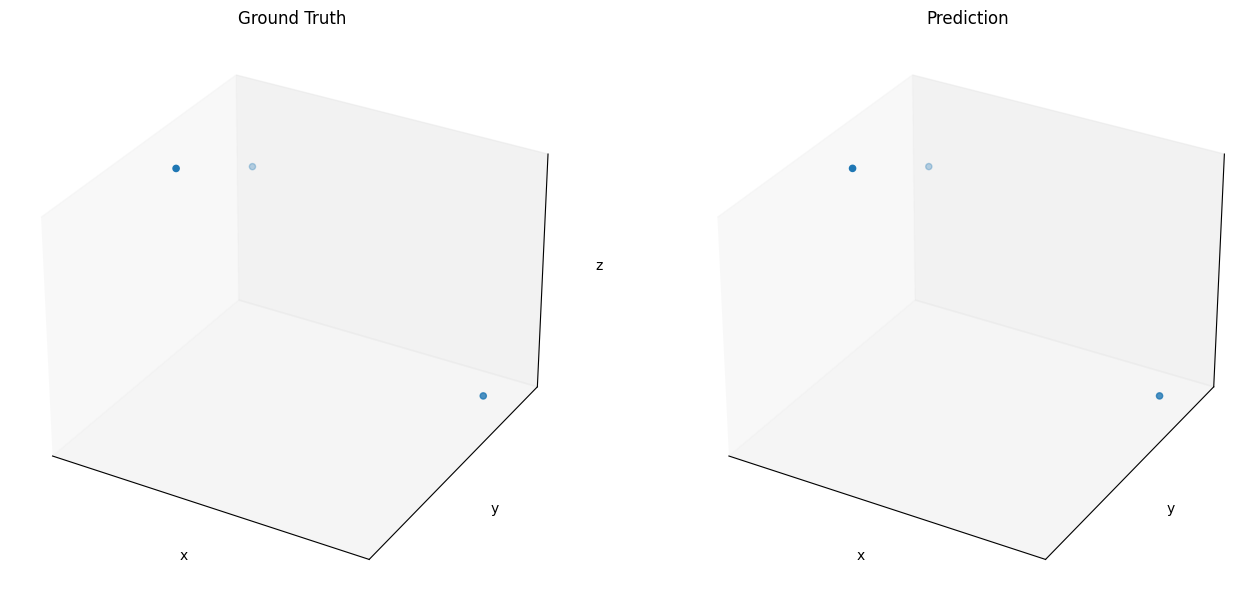

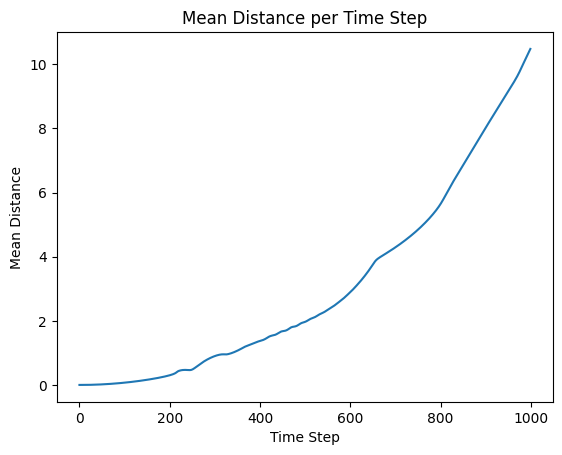

In [ ]:
from datagen import generate_n_body_scene
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# animate the scene in 3d comparing the predicted scene with the actual scene
def get_new_pos_vel(acc, pos, vel, dt=0.01):
    new_vel = vel + acc * dt
    new_pos = pos + new_vel * dt
    return new_pos, new_vel

def sim_accelerations(positions, masses, G=1.0, softening=0.1):
    x = positions[:, 0:1]
    y = positions[:, 1:2]
    z = positions[:, 2:3]
    
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3 > 0] = inv_r3[inv_r3 > 0]**(-1.5)
    
    ax = G * (dx * inv_r3) @ masses
    ay = G * (dy * inv_r3) @ masses
    az = G * (dz * inv_r3) @ masses

    return np.hstack((ax, ay, az))

def generate_rollout(model, scene, n_steps=1000, dt=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    masses = torch.tensor(scene['masses']).unsqueeze(-1)
    positions = torch.tensor(scene['frames'][0]['pos'])
    velocities = torch.tensor(scene['frames'][0]['vel'])
    Gs = torch.ones_like(masses)
    softening = torch.ones_like(masses) * 0.1
    features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
    graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, RADIUS)
    graph_data = graph_data.to(device)
    pos_pred = []
    acc_pred = []
    model.eval()
    with torch.no_grad():
        for i in range(n_steps):
            out = model(graph_data)
            acc = out.cpu().numpy()
            acc_pred.append(acc)
            new_pos, new_vel = get_new_pos_vel(acc, positions, velocities, dt=dt)
            new_feats = torch.cat([new_pos, new_vel, Gs, softening, masses], dim=-1)
            graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(new_feats, new_pos, RADIUS)
            graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
            positions = new_pos
            velocities = new_vel
            pos_pred.append(new_pos)
            graph_data = graph_data.to(device)
    return np.array(pos_pred), np.array(acc_pred)

def animate_scene(scene, pos_pred):
    # create a 2 animation side by side, do in 3d    
    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_xlim(-2, 2)
    ax1.set_ylim(-2, 2)
    ax1.set_zlim(-2, 2)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.set_title('Ground Truth')


    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    ax2.set_zlim(-2, 2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_title('Prediction')
    n_bodies = len(scene['masses'])
    gt_pos = np.array([frame['pos'] for frame in scene['frames']])
    scat1 = ax1.scatter(gt_pos[0, :, 0], gt_pos[0, :, 1], gt_pos[0, :, 2])

    scat2 = ax2.scatter(pos_pred[0, :, 0], pos_pred[0, :, 1], pos_pred[0, :, 2])

    def update(frame):
        scat1._offsets3d = (gt_pos[frame, :, 0], gt_pos[frame, :, 1], gt_pos[frame, :, 2])
        scat2._offsets3d = (pos_pred[frame, :, 0], pos_pred[frame, :, 1], pos_pred[frame, :, 2])
        return scat1, scat2
    
    mean_distance_per_step = []
    for i in range(len(pos_pred)):
        mean_distance_per_step.append(mean_distance(torch.tensor(pos_pred[i]), torch.tensor(gt_pos[i])).item())
    plt.figure()
    plt.plot(range(len(mean_distance_per_step)), mean_distance_per_step)
    plt.xlabel('Time Step')
    plt.ylabel('Mean Distance')
    plt.title('Mean Distance per Time Step')
    plt.show()

    anim = FuncAnimation(fig, update, frames=len(pos_pred), blit=True, interval=10)
    return anim



scene = generate_n_body_scene(n_bodies=3)
pos_pred, acc_pred = generate_rollout(model, scene, n_steps=1000, dt=0.01)
ani = animate_scene(scene, pos_pred)
HTML(ani.to_html5_video())